This notebook is the first modeling I will do for this project. While it's not likely to be very predictive, I'm going to try to predict the authorship of a paper based only on its title, and only for the second most prolific author in the dataset. This will hopefully allow me to gain a familiarity with some of the tools for NLP modeling, and check some initial strategies to see what works and what doesn't.

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
papers_and_authors = pd.read_csv('E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-1-Data/papers_and_authors.csv')

Reading in the corrected dataset, with each paper duplicated for each author it has.

In [3]:
papers_and_authors.head()

,year,title,event_type,pdf_name,abstract,paper_text,paper_id,author_id
0,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1
1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2
2,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14
3,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155
4,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54


The dataset has 20843 entries as I would expect, 5 more than the initial uncorrected dataset that was missing three papers.

In [4]:
papers_and_authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20843 entries, 0 to 20842
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        20843 non-null  int64 
 1   title       20843 non-null  object
 2   event_type  8156 non-null   object
 3   pdf_name    20843 non-null  object
 4   abstract    20843 non-null  object
 5   paper_text  20843 non-null  object
 6   paper_id    20843 non-null  int64 
 7   author_id   20843 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 1.3+ MB


For this project I'm going to remove all of the features other than title and the author id.

In [5]:
only_auth_title = papers_and_authors.drop(['year', 'event_type', 'pdf_name', 'abstract', 'paper_text', 'paper_id'], axis=1)
only_auth_title.head()

,title,author_id
0,Self-Organization of Associative Database and ...,1
1,Self-Organization of Associative Database and ...,2
2,A Mean Field Theory of Layer IV of Visual Cort...,14
3,Storing Covariance by the Associative Long-Ter...,155
4,Storing Covariance by the Associative Long-Ter...,54


Now, I need an actual "target feature" for my model, in this case if the paper was written by Bernhard Scholkopf, author_id 1472. This function detects if his author id is in the appropriate column, and returns a 1 if it is and a 0 if it is not.

In [6]:
def bernhard_detector(row):
    if row['author_id'] == 1472:
        return 1
    else:
        return 0

Applying this function to create a new 'is_jordan' column, with the appropriate 1 or 0 as the values.

In [7]:
only_auth_title['is_bernhard'] = only_auth_title.apply(lambda row: bernhard_detector(row), axis=1)
only_auth_title.head()

,title,author_id,is_bernhard
0,Self-Organization of Associative Database and ...,1,0
1,Self-Organization of Associative Database and ...,2,0
2,A Mean Field Theory of Layer IV of Visual Cort...,14,0
3,Storing Covariance by the Associative Long-Ter...,155,0
4,Storing Covariance by the Associative Long-Ter...,54,0


Querying this dataframe for his author id I see that, as expected from the previous notebook, he wrote 62 papers.

In [8]:
len(only_auth_title.query('author_id == 1472'))

62

Now I can drop the author_id column entirely. I also need to get rid of duplicate papers, but some of the duplicated papers he wrote or co-wrote, and I need to keep those entries where 'is_bernhard' == 1. I sort the papers he wrote up to the top of the dataframe and use .drop_duplicates with keep='first' in order to remove duplicates that aren't his. 

In [9]:
is_bernhard = only_auth_title.drop('author_id', axis=1)
is_bernhard.sort_values(by='is_bernhard', ascending=False, inplace=True)
is_bernhard.drop_duplicates(subset='title', keep='first', inplace=True)
len(is_bernhard)

7241

By double checking I can see that he still has 62 papers listed as his.

In [10]:
len(is_bernhard.query('is_bernhard == 1'))

62

Having written 62 papers out of ~7000, he is responsible for about ~0.8% of the dataset as a whole, making this a very imbalanced dataset.

In [11]:
is_bernhard.is_bernhard.value_counts(normalize=True)

0    0.991438
1    0.008562
Name: is_bernhard, dtype: float64

Now I split my features into X: the title still in plaintext as a dataframe, and y: the 'is_bernhard' column flattened into a 1-dimentional array.

In [12]:
X = is_bernhard['title'].to_frame()
y = is_bernhard['is_bernhard'].values.flatten()

Creating my train and test split, with the train size set to 75%.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, train_size=0.75)

Now I can change the title's plaintext into something actually usable by a model. In this case I will be using scikit-learn's TfidfVectorizer, which is essentially an advanced "bag of words" representation. Each word in each title is made into a feature, with the values being the number of times that word appears in that title. Then the values are normalized across all of the words in all of the titles.

In this case, I will fit and transform on the train set, and only transform the test set. The shape tells me I have 5430 titles in the train set, as expected, and 4865 columns each representing a word.

In [14]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train.title)
X_train.shape

(5430, 4865)

This code shows the statistics of the vectorized titles. While most words aren't in a given title, I can see that the proper normalized values are present.

In [15]:
X_train_array = X_train.toarray()
df_X_train = pd.DataFrame(X_train_array, columns=tfidf.get_feature_names_out())
df_X_train.describe()

,000,17,1993,1d,25,2d,360,3d,3n2,40,...,ying,yosida,you,young,your,zero,zeroth,zeta,zip,zype
count,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,...,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000
mean,0.000076,0.000111,0.000066,0.000069,0.000073,0.000539,0.000087,0.001925,0.000079,0.000055,...,0.000082,0.000091,0.000231,0.000068,0.000167,0.000462,0.000066,0.000158,0.000080,0.000078
std,0.005616,0.008207,0.004881,0.005070,0.005383,0.015093,0.006377,0.027300,0.005832,0.004057,...,0.006072,0.006699,0.009963,0.005014,0.008807,0.014007,0.004896,0.008239,0.005927,0.005735
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.413822,0.604786,0.359673,0.373624,0.396649,0.483157,0.469903,0.580021,0.429781,0.298990,...,0.447406,0.493604,0.514689,0.369483,0.529268,0.477575,0.360781,0.442530,0.436726,0.422571


Now I only transform on the test set. It still has the same number of features as the train set.

In [16]:
X_test = tfidf.transform(X_test.title)
X_test.shape

(1811, 4865)

For these models I will only be using a simple logistic regression model, as this is more about establishing a baseline of performance than finding the absolute best model.

First I fit on the train set and predict the test set, with no additional parameters.

In [17]:
lr = LogisticRegression(random_state=21)

lr.fit(X_train, y_train)

predictions = lr.predict(X_test)

The model has an accuracy of almost 99%, but an AUC of exactly 0.5 and a 0 for a recall score. Plotting the confusion matrix confirms that this model simply predicted that Bernhard wrote none of the papers. Obviously this isn't what I'm looking for.

In [18]:
accuracy = lr.score(X_test, y_test)
auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test, predictions)
print('Accuracy:', accuracy)
print('AUC:', auc)
print('Recall score:', recall)

Accuracy: 0.9906129210381005
AUC: 0.5
Recall score: 0.0


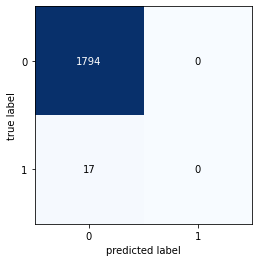

In [19]:
cm = confusion_matrix(y_test, predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

Next I tried using class weights, in this case an incorrect guess on a Bernhard paper is penalized 99x more harshly than on another paper. Everything else is exactly the same as the previous model

In [20]:
weights = {0:1, 1:99}
lr2 = LogisticRegression(random_state=21, class_weight=weights)
lr2.fit(X_train, y_train)
predictions2 = lr2.predict(X_test)

Looking at the model scoring methods, I can see that this model is slightly better than the previous one, but not amazing by any means. 4/17 papers he wrote were sucessfully predicted, along with 24 false positives. 

In [21]:
accuracy2 = lr2.score(X_test, y_test)
auc2 = roc_auc_score(y_test, predictions2)
recall2 = recall_score(y_test, predictions2)
print('Accuracy:', accuracy2)
print('AUC:', auc2)
print('Recall score:', recall2)

Accuracy: 0.9795692987299834
AUC: 0.6109580956128271
Recall score: 0.23529411764705882


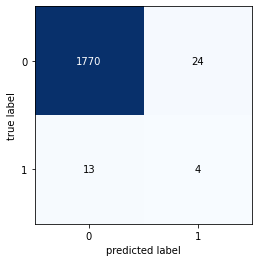

In [22]:
cm2 = confusion_matrix(y_test, predictions2)
fig, ax = plot_confusion_matrix(conf_mat=cm2)
plt.show()

Later, I was curious to see if I was overfitting, so I repeated the above test but predicted on the train data instead of the test data. This seem s like it could be overfitting, but I will need cross validation to check. I will do these checks in a later notebook

In [23]:
predictions2_train = lr2.predict(X_train)

In [24]:
accuracy2_train = lr2.score(X_train, y_train)
auc2_train = roc_auc_score(y_train, predictions2_train)
recall2_train = recall_score(y_train, predictions2_train)
print('Accuracy:', accuracy2_train)
print('AUC:', auc2_train)
print('Recall score:', recall2_train)

Accuracy: 0.9915285451197053
AUC: 0.9957288765088208
Recall score: 1.0


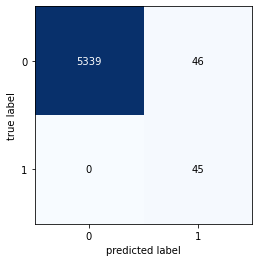

In [25]:
cm2_train = confusion_matrix(y_train, predictions2_train)
fig, ax = plot_confusion_matrix(conf_mat=cm2_train)
plt.show()

Next I wanted to try oversampling and undersampling as methods. I created a new train/test split so that I could oversample or undersample it accordingly. This is the "oversample" split, with the same random state as the last split. 

In [26]:
X_train_over, X_test_over, y_train_over, y_test_over = \
    train_test_split(X, y, random_state=21, train_size=0.75)

Here is the actual oversampling. I only oversample the train set, and leave the test set as it was. 

In [27]:
oversample = RandomOverSampler(random_state=21)

X_train_over, y_train_over = oversample.fit_resample(X_train_over, y_train_over)

Again TfidfVectorizing the data, the shapes indicate that our train set now has 10,770 papers in it, with many being duplicates of Bernhard's papers.

In [28]:
tfidf = TfidfVectorizer()

X_train_over = tfidf.fit_transform(X_train_over.title)
X_test_over = tfidf.transform(X_test_over.title)

print(X_train_over.shape)
print(X_test_over.shape)

(10770, 4865)
(1811, 4865)


And fitting the Logistic regression model to it, then predicting on the test set.

In [29]:
lr_over = LogisticRegression(random_state=21)
lr_over.fit(X_train_over, y_train_over)
predictions_over = lr_over.predict(X_test_over)

The model's scores show that this model performed worse than the weighted example, with only 2/17 papers predicted. It's possible that this is due to some random variance, however, so cross validation will again be necissary to check.

In [30]:
accuracy_over = lr_over.score(X_test_over, y_test_over)
auc_over = roc_auc_score(y_test_over, predictions_over)
recall_over = recall_score(y_test_over, predictions_over)
print('Accuracy:', accuracy_over)
print('AUC:', auc_over)
print('Recall score:', recall_over)

Accuracy: 0.9784649364991718
AUC: 0.5521345662010624
Recall score: 0.11764705882352941


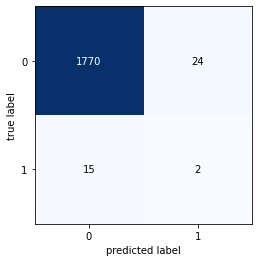

In [31]:
cm_over = confusion_matrix(y_test_over, predictions_over)
fig, ax = plot_confusion_matrix(conf_mat=cm_over)
plt.show()

Now the undersampling split, again with the same random state as before

In [32]:
X_train_under, X_test_under, y_train_under, y_test_under = \
    train_test_split(X, y, random_state=21, train_size=0.75)

Again only undersampling on the train set

In [33]:
undersample = RandomUnderSampler(random_state=21)

X_train_under, y_train_under = undersample.fit_resample(X_train_under, y_train_under)

TfidfVectorizing the titles, the shapes indicate that only 90 papers remain in the train set.

In [34]:
tfidf = TfidfVectorizer()

X_train_under = tfidf.fit_transform(X_train_under.title)
X_test_under = tfidf.transform(X_test_under.title)

print(X_train_under.shape)
print(X_test_under.shape)

(90, 391)
(1811, 391)


Fitting the LogisticRegression model to the undersampled data.

In [35]:
lr_under = LogisticRegression(random_state=21)
lr_under.fit(X_train_under, y_train_under)
predictions_under = lr_under.predict(X_test_under)

The scores here show a marked difference to the previous ones. The accuracy has tanked, while recall score has gone way up to over 50%. The overall AUC remains around the same as the previous models.

In [36]:
accuracy_under = lr_under.score(X_test_under, y_test_under)
auc_under = roc_auc_score(y_test_under, predictions_under)
recall_under = recall_score(y_test_under, predictions_under)
print('Accuracy:', accuracy_under)
print('AUC:', auc_under)
print('Recall score:', recall_under)

Accuracy: 0.6686913307564881
AUC: 0.6288445143943866
Recall score: 0.5882352941176471


The confusion matrix indicates that there are now a huge number of false positives, around half the size of the true negatives. The model was able to predict 10/17 of his papers, but overall this seems like a step back, and it's possible I did something incorrectly while undersampling the data. Or undersampling is just not an appropriate method for this type of data.

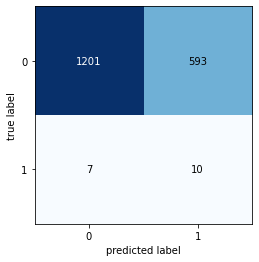

In [37]:
cm_under = confusion_matrix(y_test_under, predictions_under)
fig, ax = plot_confusion_matrix(conf_mat=cm_under)
plt.show()

One strategy I should have used was the "stratify" parameter in train_test_split. This ensures that the ratio of positive and negative cases remains the same across the train and test splits, and is very useful on highly imbalanced datasets. I will use it in subsequent notebooks.

In [38]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, random_state=21, train_size=0.75, stratify=y)

print(y_test_t.tolist().count(1))

16
